# Bias \& Variance

In [88]:
%run src.ipynb
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

data = np.loadtxt('../data/data_BiasVariance_1.csv', delimiter=',')

X = data[:,0].reshape((-1,1))
y = data[:,1].reshape((-1,1))

### Split the data into traing (60%), dev (20%), and test (20%) sets

In [89]:
def split_data(X,y):
    X_train, X_, y_train, y_ = train_test_split(X,y,train_size=0.6, random_state=80)
    X_dev, X_test, y_dev, y_test = train_test_split(X_,y_,train_size=0.5, random_state=80)
    print(f"X.shape = {X.shape}, X_train.shape = {X_train.shape}, X_dev.shape = {X_dev.shape}, X_test.shape = {X_test.shape}")
    print(f"y.shape = {y.shape}, y_train.shape = {y_train.shape}, y_dev.shape = {y_dev.shape}, y_test.shape = {y_test.shape}")
    
    return X_train, y_train, X_dev, y_dev, X_test, y_test

X_train, y_train, X_dev, y_dev, X_test, y_test = split_data(X,y)

X.shape = (100, 1), X_train.shape = (60, 1), X_dev.shape = (20, 1), X_test.shape = (20, 1)
y.shape = (100, 1), y_train.shape = (60, 1), y_dev.shape = (20, 1), y_test.shape = (20, 1)


### A for loop to evaluate polynomial models of different degrees

In [90]:
def plot_train(regr,X_train,y_train,X_dev,y_dev,max_degree):
    train_MSE = []
    dev_MSE = []
    models = []
    norm_ls = []

    degrees = range(1,max_degree)
    
    for degree in degrees:
        # Generate the mapped features
        poly = PolynomialFeatures(degree=degree, include_bias=True)
        X_trainMapped = poly.fit_transform(X_train)
    
        # Normalize the mapped training data
        norm_l = tf.keras.layers.Normalization(axis=-1)
        norm_l.adapt(X_trainMapped)
        X_trainMappedn = norm_l(X_trainMapped)
        norm_ls.append(norm_l)
    
        # Fit the normalized mapped training data
        regr.fit(X_trainMappedn,y_train)
        models.append(regr)

        # Compute mean-squared-error for the training data
        yPredict = regr.predict(X_trainMappedn)
        train_MSE.append(0.5*mean_squared_error(y_train,yPredict))
    
        # Map and normalize the dev data
        X_devMapped = poly.fit_transform(X_dev)
        X_devMappedn = norm_l(X_devMapped)
    
        # Compute mean-square-error for the dev data
        yPredict = regr.predict(X_devMappedn)
        dev_MSE.append(0.5*mean_squared_error(y_dev,yPredict))
    

    print(f"train_MSE, dev_MSE =\n {np.c_[train_MSE,dev_MSE]}")

    plt.figure(figsize=[6,4])
    plt.plot(degrees,train_MSE,'xk',label='train')
    plt.plot(degrees,dev_MSE,'sb',label='dev')
    plt.xlabel('$n$')
    plt.ylabel('MSE')
    plt.legend(frameon=False)

### Train a linear model

train_MSE, dev_MSE =
 [[484.6243221  856.02817181]
 [416.10673351 717.34942565]
 [408.83055963 750.8512644 ]
 [399.94850651 770.25432321]
 [399.01451678 781.7020306 ]]


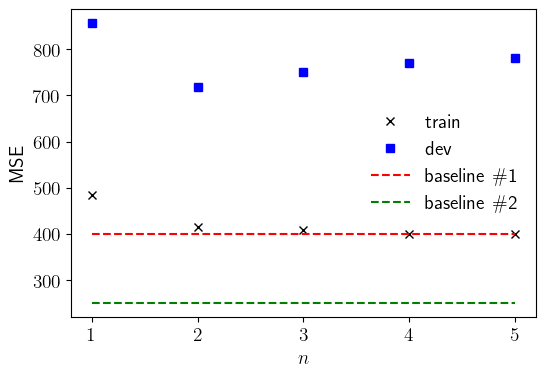

In [91]:
max_degree = 6
base_line1 = 400
base_line2 = 250
regr = linear_model.LinearRegression(fit_intercept=True)
plot_train(regr,X_train,y_train,X_dev,y_dev,max_degree)
plt.plot(degrees,base_line1*np.ones(len(degrees)),'--r',label='baseline \#1')
plt.plot(degrees,base_line2*np.ones(len(degrees)),'--g',label='baseline \#2')
plt.legend(frameon=False)
plt.show()

### Analysis
Looking at above figure, if one we consider the high baseline, then our model (say when $n=4$) has a high variance since it fits the training data very well (even better than the baseline) but the dev datset has a large mean-squared-error. However, if we consider the low baseline, we realize that we have in fact a high bias since the mean-squared-error is high for the both training and dev data sets. Below we attempt to reduce this **bias**.

### Collect more features:
Imagine that we somehow got access to more data: now two features

X.shape = (100, 2), X_train.shape = (60, 2), X_dev.shape = (20, 2), X_test.shape = (20, 2)
y.shape = (100, 1), y_train.shape = (60, 1), y_dev.shape = (20, 1), y_test.shape = (20, 1)
train_MSE, dev_MSE =
 [[315.9285463  498.20616711]
 [267.98016066 391.00997233]
 [241.55122966 518.4670612 ]
 [235.29346954 552.95630224]
 [192.77586948 804.2878601 ]]


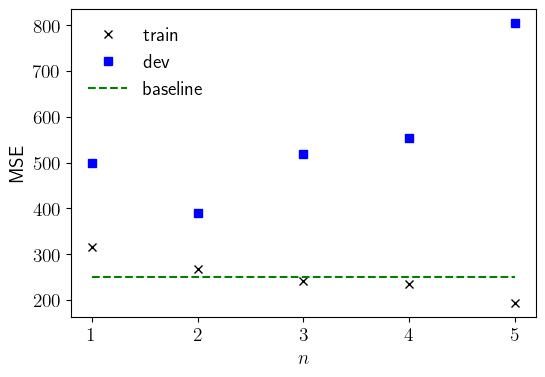

In [92]:
data = np.loadtxt('../data/data_BiasVariance_2.csv', delimiter=',')

X = data[:,:-1].reshape((-1,2))
y = data[:,-1].reshape((-1,1))
X_train, y_train, X_dev, y_dev, X_test, y_test = split_data(X,y)
regr = linear_model.LinearRegression(fit_intercept=True)
plot_train(regr,X_train,y_train,X_dev,y_dev,max_degree)
plt.plot(degrees,base_line2*np.ones(len(degrees)),'--g',label='baseline')
plt.legend(frameon=False)
plt.show()

### What now?
Now we have an **overfitting** problem! The training data is fitted very well, and better than the baseline but the dev set is not lookin good!

### Use regularization to reduce overfitting
We pick $n=4$ and try to reduce the overfitting by adding an appropriate regulaziation. We use Scikit Ridge class to perform this task

### A for loop to evaluate the model for different $\lambda$ values

In [93]:
def plot_train_regularization(X_train,y_train,X_dev,y_dev,degree,lambdas):
    train_MSE = []
    dev_MSE = []
    models = []
    norm_ls = []
    
    for lambda_ in lambdas:
        # Generate the mapped features
        poly = PolynomialFeatures(degree=degree, include_bias=True)
        X_trainMapped = poly.fit_transform(X_train)
    
        # Normalize the mapped training data
        norm_l = tf.keras.layers.Normalization(axis=-1)
        norm_l.adapt(X_trainMapped)
        X_trainMappedn = norm_l(X_trainMapped)
        norm_ls.append(norm_l)
    
        # Fit the normalized mapped training data
        regr = linear_model.Ridge(alpha=lambda_)
        regr.fit(X_trainMappedn,y_train)
        models.append(regr)

        # Compute mean-squared-error for the training data
        yPredict = regr.predict(X_trainMappedn)
        train_MSE.append(0.5*mean_squared_error(y_train,yPredict))
    
        # Map and normalize the dev data
        X_devMapped = poly.fit_transform(X_dev)
        X_devMappedn = norm_l(X_devMapped)
    
        # Compute mean-square-error for the dev data
        yPredict = regr.predict(X_devMappedn)
        dev_MSE.append(0.5*mean_squared_error(y_dev,yPredict))
    
    print(f"train_MSE, dev_MSE =\n {np.c_[train_MSE,dev_MSE]}")

    plt.figure(figsize=[6,4])
    plt.plot(lambdas,train_MSE,'xk',label='train')
    plt.plot(lambdas,dev_MSE,'sb',label='dev')
    plt.xlabel('$\lambda$')
    plt.ylabel('MSE')
    plt.legend(frameon=False)
    
    return train_MSE, dev_MSE


## Train the model

train_MSE, dev_MSE =
 [[235.29341274 552.96385407]
 [242.50828201 501.01402795]
 [244.44079465 482.030571  ]
 [246.20528751 465.84852198]
 [249.2905091  449.30236648]
 [255.88126374 438.09526785]
 [263.81465717 445.68341756]
 [277.70000605 474.84124606]]


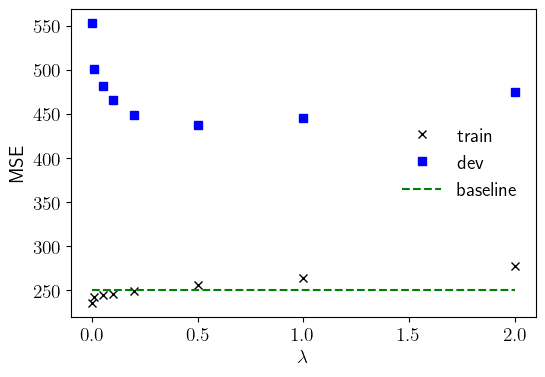

The lowest dev MSE occurs for lambda = 0.5


In [94]:
lambdas = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2]
degree = 4
train_MSE, dev_MSE = plot_train_regularization(X_train,y_train,X_dev,y_dev,degree,lambdas)
plt.plot(lambdas,base_line2*np.ones(len(lambdas)),'--g',label='baseline')
plt.legend(frameon=False)
plt.show()

lambda_ = lambdas[np.argmin(dev_MSE)]
print(f"The lowest dev MSE occurs for lambda = {lambda_}")

## Learning curves

In [95]:
data = np.loadtxt('../data/data_BiasVariance_3.csv', delimiter=',')

X = data[:,:-1].reshape((-1,2))
y = data[:,-1].reshape((-1,1))
X_train, y_train, X_dev, y_dev, X_test, y_test = split_data(X,y)

X.shape = (1000, 2), X_train.shape = (600, 2), X_dev.shape = (200, 2), X_test.shape = (200, 2)
y.shape = (1000, 1), y_train.shape = (600, 1), y_dev.shape = (200, 1), y_test.shape = (200, 1)


In [96]:
def plot_train_regularization(X_train,y_train,X_dev,y_dev,degree,lambda_,base_line):
    train_MSE = []
    dev_MSE = []
    models = []
    norm_ls = []
    numData = []
    percents = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    
    X_train_total = X_train
    y_train_total = y_train
    length = X_train_total.shape[0]
    
    for percent in percents:
        
        index = round(length*percent/100)
        X_train = X_train_total[:index,:]
        y_train = y_train_total[:index,:]
        numData.append(X_train.shape[0])
        # Generate the mapped features
        poly = PolynomialFeatures(degree=degree, include_bias=True)
        X_trainMapped = poly.fit_transform(X_train)
    
        # Normalize the mapped training data
        norm_l = tf.keras.layers.Normalization(axis=-1)
        norm_l.adapt(X_trainMapped)
        X_trainMappedn = norm_l(X_trainMapped)
        norm_ls.append(norm_l)
    
        # Fit the normalized mapped training data
        regr = linear_model.Ridge(alpha=lambda_)
        regr.fit(X_trainMappedn,y_train)
        models.append(regr)

        # Compute mean-squared-error for the training data
        yPredict = regr.predict(X_trainMappedn)
        train_MSE.append(0.5*mean_squared_error(y_train,yPredict))
    
        # Map and normalize the dev data
        X_devMapped = poly.fit_transform(X_dev)
        X_devMappedn = norm_l(X_devMapped)
    
        # Compute mean-square-error for the dev data
        yPredict = regr.predict(X_devMappedn)
        dev_MSE.append(0.5*mean_squared_error(y_dev,yPredict))
    
    print(f"train_MSE, dev_MSE =\n {np.c_[train_MSE,dev_MSE]}")

    plt.figure(figsize=[6,4])
    plt.plot(numData,train_MSE,'xk',label='train')
    plt.plot(numData,dev_MSE,'sb',label='dev')
    plt.plot(numData,base_line*np.ones(len(numData)),'--g',label='baseline')
    plt.xlabel('$m$')
    plt.ylabel('MSE')
    plt.legend(frameon=False)
    plt.show()

train_MSE, dev_MSE =
 [[247.16353316 346.7702519 ]
 [294.95831614 314.22808069]
 [283.40931079 311.37526997]
 [281.1204048  312.60221833]
 [279.66508507 303.90896795]
 [268.93905607 302.32272081]
 [267.16874471 305.1054877 ]
 [277.69726537 302.33572948]
 [274.65046    297.41963253]
 [270.09081681 297.35997097]]


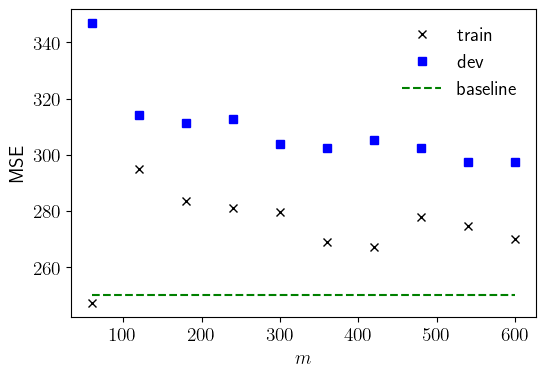

In [97]:
plot_train_regularization(X_train,y_train,X_dev,y_dev,degree,lambda_,250)